# <center> "Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects" <br> Reproducing simulation results

#### 5.1 Simulation Setting and Prior Distributions

The simulated data set contains 2 years of weekly data, sales, three media and one control variable
(price). Media variables are generated by adding white noise to a sinusoidal seasonality with one
year as a period; the control variable is generated as an ARIMA time series. For each media, the
spend is scaled to be from 0 to 1 for convenience. Table 1 contains the parameters used in the model
in (7) to generate sales as the response variable. Here we assume no transformation is used on the
response variable. Figure 4 shows the time series plots of the sales and the media spend. Due to
the data generation mechanism, weekly spend of all media have the same marginal distribution.
Figure 4d shows the histogram of weekly spend of Media 1, which is quite spread out from 0 to 1.
The media variables are also very weakly correlated with a correlation of 0.09.

#### Features

- date (day)
- media channels (x3) - white noise with sinusoidal seasonality with one year as a period
- control variable - ARIMA time series
- sales - response variable 

In [2]:
conda activate ./envs


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

import pymc3 as pm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy
from statsmodels.tsa import arima_process as arima

import matplotlib.pyplot as plt
import arviz as az

import random
import os
import math


In [10]:
from src.utils import \
 geoDecay, delayed_adstock, carryover_theano, beta_hill, response_additive, yearly_period

In [11]:
random.seed(12345)

## Carryover effect

$ x_{t,m}^{*} = addstock(x_{t-L+1,m,...,x_{t,m}; w_m,L}) = \frac{\sum_{l=1}^{L-1}{w_m(l)\cdot x_{t-l,m}}}{\sum_{l=1}^{L-1}{w_m(l)}}  \\ $
 - 
$ a)\ w_m^{g}(l,\alpha_m) = \alpha_m^{l} \text{   geometric decay} \\ \\ b)\ w_m^{d}(l,\alpha_m,\theta_m) = \alpha_m^{(l-\theta_m)^{2}} \text{   delayed decay} \\ l = 0,...,L-1 ,\ 0<\alpha_m <1, \ 0<\theta_m<L-1 $

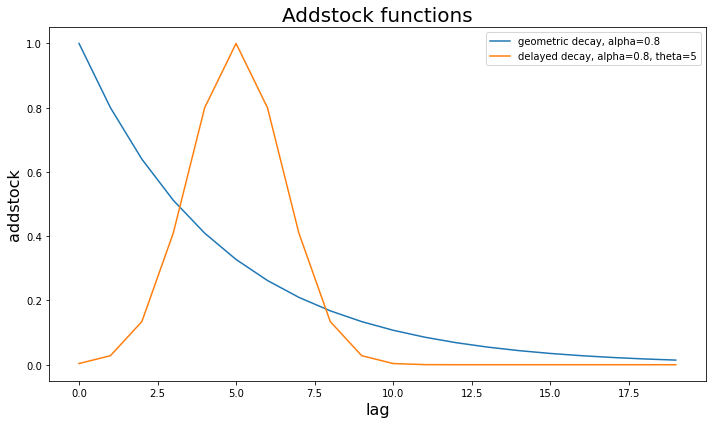

In [12]:
alpha = 0.8
theta = 5
L=20
x = np.linspace(start=0, stop=19, num=L)

plt.figure(figsize=(10,6))
plt.plot(x,geoDecay(alpha=alpha, L=L)[::-1], label = 'geometric decay, alpha={}'.format(alpha))
plt.plot(x,delayed_adstock(alpha=alpha, theta=theta, L=L)[::-1], 
         label='delayed decay, alpha={}, theta={}'.format(alpha,theta))
plt.legend()
plt.title('Addstock functions', fontsize=20)
plt.xlabel('lag',fontsize=16)
plt.ylabel('addstock', fontsize=16)
plt.tight_layout()

# Shape effect

$ \beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m) = \beta_m - \frac{\kappa_m^{S_m}\cdot \beta_m}{x_{t,m}^{S_m} +\kappa_m^{S_m} } \\ $

In [13]:
beta = [0.3,0.3925,0.3,0.3,0.8,1.144]
S = [1,0.748,2,0.5,2,1.867]
K = [0.5,0.95,0.5,0.5,1.5,2]
colors = ['k','k','r','g','b','b']
lines = ['-','--','-','-','-','--']
labels = ['β={} S={} K={}'.format(b,s,k) for (b,s,k) in zip(beta,S,K)]

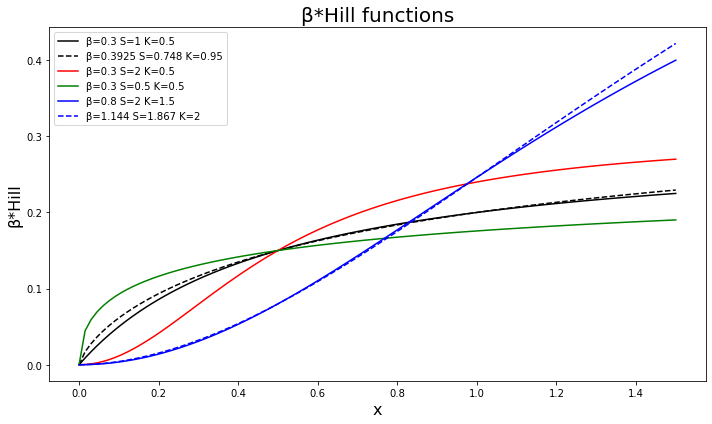

In [14]:
x = np.linspace(start=0, stop=1.5, num=100)

plt.figure(figsize=(10,6))
for i in range(len(beta)):
    b = beta[i]
    s = S[i]
    k = K[i]
    plt.plot(x, beta_hill(x, s, k, b), label=labels[i], color=colors[i], linestyle=lines[i])

plt.legend()
plt.title('β*Hill functions', fontsize=20)
plt.xlabel('x',fontsize=16)
plt.ylabel('β*Hill', fontsize=16)
plt.tight_layout()


״The parameters of βHill are essentially unidentifiable in some scenarios.." (e.g - black and blue curves ) <br>

# Simulate data

## Defs (channels)

In [15]:
start = 0
end = 52 * 2
duration = int(end - start)
intervals = 1
period = 52
phase_shift = 0
vertical_shift = 0
amplitude = 1

mvn_mue = [0, 0, 0]
mvn_sig = 1.4
mvn_cor = 0.00

time = np.arange(start, end, intervals)

## media channels
### 0.09 correlation

In [16]:
media_channels = yearly_period(time, amplitude=amplitude,
                               vertical_shift=vertical_shift, period=period, phase_shift=0)

In [17]:
# create covariance matrix for media channels
cov = np.zeros((3,3)) + mvn_cor
np.fill_diagonal(cov,mvn_sig)

In [18]:
# add gaussian noise
random.seed(0)

noise_1, noise_2, noise_3 = np.random.multivariate_normal(mvn_mue, cov, int(duration / intervals)).T
# noise_1 = np.random.normal(0,mvn_sig,int(duration/intervals))
# noise_2 = np.random.normal(0,mvn_sig,int(duration/intervals))
# noise_3 = np.random.normal(0,mvn_sig,int(duration/intervals))

scaler_minmax = MinMaxScaler()

# media channel 1
media_ch1 = media_channels + noise_1
media_ch1 = np.expand_dims(media_ch1, axis=1)
media_ch1 = scaler_minmax.fit_transform(media_ch1)

# media channel 2
media_ch2 = media_channels + noise_2
media_ch2 = np.expand_dims(media_ch2, axis=1)
media_ch2 = scaler_minmax.fit_transform(media_ch2)

# media channel 1
media_ch3 = media_channels + noise_3
media_ch3 = np.expand_dims(media_ch3, axis=1)
media_ch3 = scaler_minmax.fit_transform(media_ch3)

### Control variable - price (ARIMA)

In [19]:
np.random.seed(12345)
arparams = np.array([.7, .6])
maparams = np.array([.1, .02])
ar = np.r_[1, arparams]  # add zero-lag and negate
ma = np.r_[1, maparams]  # add zero-lag
price = arima.arma_generate_sample(ar, ma, duration)
price = np.expand_dims(price, axis=1)

scaler_minmax = MinMaxScaler(feature_range=(-0.4, 0.4))
price = scaler_minmax.fit_transform(price)

### Raw Data

In [20]:
dates = np.expand_dims(time,axis=1)
df = (pd.DataFrame(data=np.hstack((dates, media_ch1, media_ch2, media_ch3, price)),
      columns=['date','ch1','ch2','ch3','price']))
print(df.shape)
df.head(2)

(104, 5)


,date,ch1,ch2,ch3,price
0,0.0,0.387985,0.813167,0.692665,0.016961
1,1.0,0.342402,0.461704,0.602767,0.124931


In [21]:
media_ch1.shape

(104, 1)

## Response surface
<br>
<br>
$ y_t = \tau + \sum_{m=1}^{M}{\beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m)} + \sum_{c=1}^{C}{\gamma_c \cdot z_{t,c}} + \epsilon_t \\ $





Combining the Carryover and the Shape Effect <br>
Since media spend ineach time period is relatively small compared to the cumulative spend across multiple time periods, <br> 
I apply the shape transformation after the adstock transformation

### Prior parameter selection:

In [22]:
ch1_dict = {'alpha': 0.6, 'theta': 5, 'L': 13, 'decay': 'delayed', 'S': 1, 'K': 0.2, 'beta': 0.8}
ch2_dict = {'alpha': 0.8, 'theta': 3, 'L': 13, 'decay': 'delayed', 'S': 2, 'K': 0.2, 'beta': 0.6}
ch3_dict = {'alpha': 0.8, 'theta': 4, 'L': 13, 'decay': 'delayed', 'S': 2, 'K': 0.2, 'beta': 0.3}
channel_params = {'ch1': ch1_dict, 'ch2': ch2_dict, 'ch3': ch3_dict}
tau = 4
lamb = [-0.5]
var_eps = 0.05 ** 2

treatment_columns = ['ch1', 'ch2', 'ch3']
control_columns = ['price']
date_col = 'date'

simulate = True

In [31]:
sales = response_additive(df=df, treatment_columns=treatment_columns,
                                 channel_params=channel_params,
                                 control_columns=control_columns,
                                 lamb=lamb)
sales = np.array(sales) + tau
if simulate:
    noise = np.random.normal(0, var_eps, sales.shape[0])
    sales += noise

Time:  0.003414484000018092


### Plotting

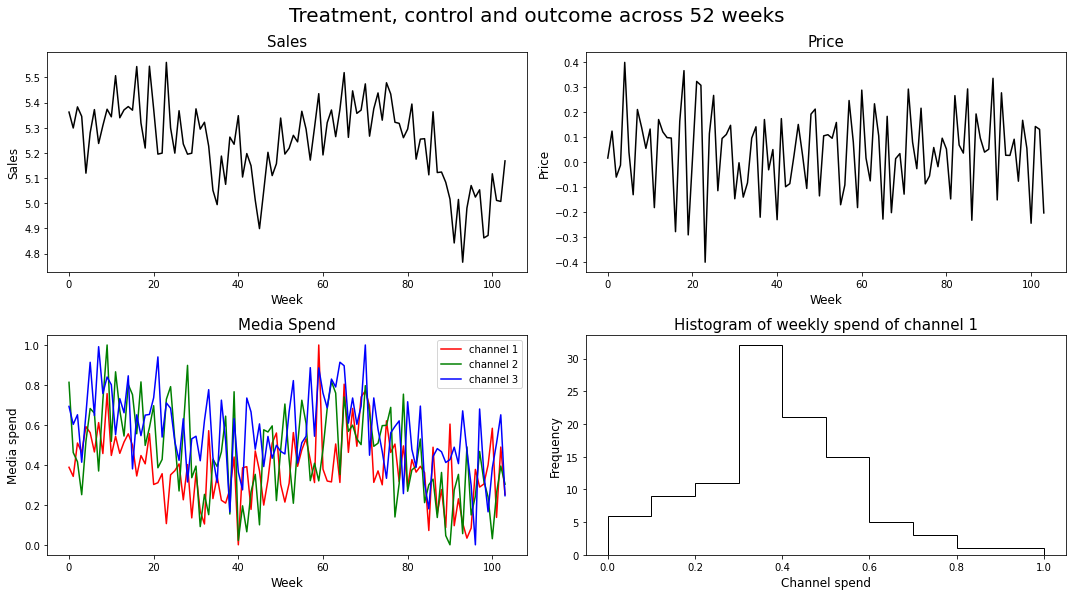

In [32]:
fig, axes = plt.subplots(2,2, figsize=(15, 8))

axes[0,0].set_xlabel('Week',fontsize=12)
axes[0,0].set_ylabel('Sales',fontsize=12)
axes[0,0].set_title('Sales',fontsize=15)
axes[0,0].plot(time,sales, color='k')

axes[0,1].plot(time,price, color='k')
axes[0,1].set_xlabel('Week', fontsize=12)
axes[0,1].set_ylabel('Price',fontsize=12)
axes[0,1].set_title('Price',fontsize=15)

axes[1,0].plot(time,media_ch1,color='r')
axes[1,0].plot(time,media_ch2,color='g')
axes[1,0].plot(time,media_ch3,color='b')

axes[1,0].set_xlabel('Week',fontsize=12)
axes[1,0].set_ylabel('Media spend',fontsize=12)
axes[1,0].legend(['channel 1','channel 2','channel 3'], loc=0)
axes[1,0].set_title('Media Spend',fontsize=15)

axes[1,1].hist(media_ch1, bins=10,  histtype='step', color='k')
axes[1,1].set_xlabel('Channel spend',fontsize=12)
axes[1,1].set_ylabel('Frequency',fontsize=12)
axes[1,1].set_title('Histogram of weekly spend of channel 1', fontsize=15)


fig.suptitle('Treatment, control and outcome across {} weeks'.format(period),fontsize=20, y=1.03 )
fig.tight_layout()

<bound method Figure.tight_layout of <Figure size 360x288 with 2 Axes>>

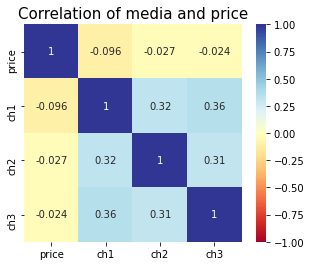

In [33]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5, 4))
corr = df[['price', 'ch1','ch2','ch3']].corr()
# sns.set(font_scale=1)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='RdYlBu',
            square=True, ax=ax, annot=True, vmin=-1, vmax=1)
ax.set_title('Correlation of media and price', fontsize=15)
f.tight_layout

In [34]:
print(f"Higher correlation between channels than in paper,\nVariance was set to {mvn_sig},\nCovariance between channels was set to {mvn_cor}")

Higher correlation between channels than in paper,
Variance was set to 1.4,
Covariance between channels was set to 0.0


### Pearson's r (squared) $r^2$ (coefficient of determination for simple linear regression) 

In [35]:
_, _, r_value1, _, _ = scipy.stats.linregress(df['ch1'], sales)
_, _, r_value2, _, _ = scipy.stats.linregress(df['ch2'], sales)
_, _, r_value3, _, _ = scipy.stats.linregress(df['ch3'], sales)
_, _, r_value4, _, _ = scipy.stats.linregress(df['price'], sales)
_, _, r_value5, _, _ = scipy.stats.linregress(noise, sales)
r2 = pd.DataFrame([r_value1,r_value2,r_value3,r_value4,r_value5]).T
columns = df.columns.tolist()[1:] + ['noise']
r2.columns = columns=columns
r2 = r2**2
r2.style.format({
    'ch1': '{:,.2%}'.format,
    'ch2': '{:,.2%}'.format,
    'ch3': '{:,.2%}'.format,
    'price': '{:,.2%}'.format,
    'noise': '{:,.2%}'.format,
})

,ch1,ch2,ch3,price,noise
0,17.21%,23.06%,15.27%,24.00%,0.01%


### Coefficient of determination $r^2$ ( for $ f_i(x_i)=sales_{pred} $) 

In [36]:
control_columns_none = None
date_col = 'date'
simulate = False
 
channel_params1 = {'ch1':ch1_dict}
treatment_columns1 = ['ch1']

channel_params2 = {'ch2':ch2_dict}
treatment_columns2 = ['ch2']

channel_params3 = {'ch3':ch3_dict}
treatment_columns3 = ['ch3']

list_for_pred = [(channel_params1,treatment_columns1,control_columns_none),
                (channel_params2,treatment_columns2,control_columns_none),
                (channel_params3,treatment_columns3,control_columns_none),
                (None,None,['price']),
                (channel_params,treatment_columns,control_columns)]

In [37]:
r2_list = []
for i in range(5):
    
    channel_params_tmp = list_for_pred[i][0]
    treatment_columns_tmp = list_for_pred[i][1]
    control_columns_tmp = list_for_pred[i][2]
    
    sales_pred = response_additive(df=df, treatment_columns=treatment_columns_tmp,
                                     channel_params=channel_params_tmp,
                                     control_columns=control_columns_tmp,
                                     lamb=lamb)
    _, _, r_value, _, _ = scipy.stats.linregress(sales_pred, sales)
    r2_list.append(r_value**2)


Time:  0.001344912000149634
Time:  0.0020776929998191918
Time:  0.0018933590001779521
Time:  0.00010315500003343914
Time:  0.0038621100000000297


In [38]:
r2 = pd.DataFrame(data=r2_list).T
columns = df.columns.tolist()[1:] + ['all']
columns = ['y_'+col for col in columns]
r2.columns = columns
r2.style.format({
    'y_ch1': '{:,.2%}'.format,
    'y_ch2': '{:,.2%}'.format,
    'y_ch3': '{:,.2%}'.format,
    'y_price': '{:,.2%}'.format,
    'y_all': '{:,.2%}'.format,
})

,y_ch1,y_ch2,y_ch3,y_price,y_all
0,55.57%,66.37%,46.47%,24.00%,100.00%


# Fitting the model

In [40]:
treatment_columns = ['ch1', 'ch2', 'ch3']
control_columns = ['price']
date_col = 'date'
simulate = True

In [43]:
!conda install mkl mkl-service

Solving environment: done

# All requested packages already installed.



In [45]:
with pm.Model():
    # Priors

    alpha = pm.Beta('alpha', 3, 3, shape=3)
    theta = pm.Normal('theta', 0, 12, shape=3)
    k = pm.Beta('k', 2, 2, shape=3)
    s = pm.Gamma('s', 3, 1, shape=3)
    beta = pm.HalfNormal('beta', sigma=1, shape=3)
    tau = pm.HalfNormal('intercept', sigma=5)
    lamb = pm.Normal('lamb', 0, 1)
    var_eps = pm.InverseGamma('noise', 0.05, 5e-4)

    # params
    ch1_dict = {'alpha': alpha[0], 'theta': theta[0], 'L': 13, 'decay': 'delayed', 'S': s[0], 'K': k[0],
                'beta': beta[0]}
    ch2_dict = {'alpha': alpha[1], 'theta': theta[1], 'L': 13, 'decay': 'delayed', 'S': s[1], 'K': k[1],
                'beta': beta[1]}
    ch3_dict = {'alpha': alpha[2], 'theta': theta[2], 'L': 13, 'decay': 'delayed', 'S': s[2], 'K': k[2],
                'beta': beta[2]}
    channel_params = {'ch1': ch1_dict, 'ch2': ch2_dict, 'ch3': ch3_dict}
    lamb_list = [lamb]

    # model
    mu = response_additive(df=df, treatment_columns=treatment_columns,channel_params=channel_params,
                           control_columns=control_columns, lamb=lamb_list)
    mu += tau

    sales_hat = pm.Normal('sales_hat', mu=mu, sigma=var_eps, observed=sales)

    print('fitting model...')
#     trace = pm.fit(method='svgd')
    posterior = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock


Time:  3.1048894689997724
fitting model...


INFO (theano.gof.compilelock): Refreshing lock /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/lock_dir/lock



You can find the C code in this temporary file: /var/folders/83/n80c0lpx1jsdsjb8tx8bg6l00000gn/T/theano_compilation_error_upqg53d9


Exception: ('The following error happened while compiling the node', Elemwise{Composite{(Switch(EQ(i0, i1), i1, (i2 * log(i0) * i3)) + Switch(EQ(i4, i1), i1, ((i5 * i3 * i6 * log(i4) * i7) / i8)) + Switch(EQ(i0, i1), i1, ((i5 * i3 * i6 * log(i0) * i3) / i8)) + Switch(EQ(i0, i1), i1, (i9 * log(i0) * i3)) + Switch(EQ(i10, i1), i1, ((i11 * i3 * i6 * log(i10) * i12) / i13)) + Switch(EQ(i0, i1), i1, ((i11 * i3 * i6 * log(i0) * i3) / i13)) + Switch(EQ(i0, i1), i1, (i14 * log(i0) * i3)) + Switch(EQ(i15, i1), i1, ((i16 * i3 * i6 * log(i15) * i17) / i18)) + Switch(EQ(i0, i1), i1, ((i16 * i3 * i6 * log(i0) * i3) / i18)) + Switch(EQ(i0, i1), i1, (i19 * log(i0) * i3)) + Switch(EQ(i20, i1), i1, ((i21 * i3 * i6 * log(i20) * i22) / i23)) + Switch(EQ(i0, i1), i1, ((i21 * i3 * i6 * log(i0) * i3) / i23)) + Switch(EQ(i0, i1), i1, (i24 * log(i0) * i3)) + Switch(EQ(i25, i1), i1, ((i26 * i3 * i6 * log(i25) * i27) / i28)) + Switch(EQ(i0, i1), i1, ((i26 * i3 * i6 * log(i0) * i3) / i28)) + Switch(EQ(i0, i1), i1, (i29 * log(i0) * i3)) + Switch(EQ(i30, i1), i1, ((i31 * i3 * i6 * log(i30) * i32) / i33)) + Switch(EQ(i0, i1), i1, ((i31 * i3 * i6 * log(i0) * i3) / i33)) + Switch(EQ(i0, i1), i1, (i34 * log(i0) * i3)) + Switch(EQ(i35, i1), i1, ((i36 * i3 * i6 * log(i35) * i37) / i38)) + Switch(EQ(i0, i1), i1, ((i36 * i3 * i6 * log(i0) * i3) / i38)) + Switch(EQ(i0, i1), i1, (i39 * log(i0) * i3)) + Switch(EQ(i40, i1), i1, ((i41 * i3 * i6 * log(i40) * i42) / i43)) + Switch(EQ(i0, i1), i1, ((i41 * i3 * i6 * log(i0) * i3) / i43)) + Switch(EQ(i0, i1), i1, (i44 * log(i0) * i3)) + Switch(EQ(i45, i1), i1, ((i46 * i3 * i6 * log(i45) * i47) / i48)) + Switch(EQ(i0, i1), i1, ((i46 * i3 * i6 * log(i0) * i3) / i48)) + Switch(EQ(i0, i1), i1, (i49 * log(i0) * i3)) + Switch(EQ(i50, i1), i1, ((i51 * i3 * i6 * log(i50) * i52) / i53)) + Switch(EQ(i0, i1), i1, ((i51 * i3 * i6 * log(i0) * i3) / i53)) + Switch(EQ(i0, i1), i1, (i54 * log(i0) * i3)) + Switch(EQ(i55, i1), i1, ((i56 * i3 * i6 * log(i55) * i57) / i58)) + Switch(EQ(i0, i1), i1, ((i56 * i3 * i6 * log(i0) * i3) / i58)) + Switch(EQ(i0, i1), i1, (i59 * log(i0) * i3)) + Switch(EQ(i60, i1), i1, ((i61 * i3 * i6 * log(i60) * i62) / i63)) + Switch(EQ(i0, i1), i1, ((i61 * i3 * i6 * log(i0) * i3) / i63)) + Switch(EQ(i0, i1), i1, (i64 * log(i0) * i3)) + Switch(EQ(i65, i1), i1, ((i66 * i3 * i6 * log(i65) * i67) / i68)) + Switch(EQ(i0, i1), i1, ((i66 * i3 * i6 * log(i0) * i3) / i68)) + Switch(EQ(i0, i1), i1, (i69 * log(i0) * i3)) + Switch(EQ(i70, i1), i1, ((i71 * i3 * i6 * log(i70) * i72) / i73)) + Switch(EQ(i0, i1), i1, ((i71 * i3 * i6 * log(i0) * i3) / i73)) + Switch(EQ(i0, i1), i1, (i74 * log(i0) * i3)) + Switch(EQ(i75, i1), i1, ((i76 * i3 * i6 * log(i75) * i77) / i78)) + Switch(EQ(i0, i1), i1, ((i76 * i3 * i6 * log(i0) * i3) / i78)) + Switch(EQ(i0, i1), i1, (i79 * log(i0) * i3)) + Switch(EQ(i80, i1), i1, ((i81 * i3 * i6 * log(i80) * i82) / i83)) + Switch(EQ(i0, i1), i1, ((i81 * i3 * i6 * log(i0) * i3) / i83)) + Switch(EQ(i0, i1), i1, (i84 * log(i0) * i3)) + Switch(EQ(i85, i1), i1, ((i86 * i3 * i6 * log(i85) * i87) / i88)) + Switch(EQ(i0, i1), i1, ((i86 * i3 * i6 * log(i0) * i3) / i88)) + Switch(EQ(i0, i1), i1, (i89 * log(i0) * i3)) + Switch(EQ(i90, i1), i1, ((i91 * i3 * i6 * log(i90) * i92) / i93)) + Switch(EQ(i0, i1), i1, ((i91 * i3 * i6 * log(i0) * i3) / i93)) + Switch(EQ(i0, i1), i1, (i94 * log(i0) * i3)) + Switch(EQ(i95, i1), i1, ((i96 * i3 * i6 * log(i95) * i97) / i98)) + Switch(EQ(i0, i1), i1, ((i96 * i3 * i6 * log(i0) * i3) / i98)) + Switch(EQ(i0, i1), i1, (i99 * log(i0) * i3)) + Switch(EQ(i100, i1), i1, ((i101 * i3 * i6 * log(i100) * i102) / i103)) + Switch(EQ(i0, i1), i1, ((i101 * i3 * i6 * log(i0) * i3) / i103)) + Switch(EQ(i0, i1), i1, (i104 * log(i0) * i3)) + Switch(EQ(i105, i1), i1, ((i106 * i3 * i6 * log(i105) * i107) / i108)) + Switch(EQ(i0, i1), i1, ((i106 * i3 * i6 * log(i0) * i3) / i108)) + Switch(EQ(i0, i1), i1, (i109 * log(i0) * i3)) + Switch(EQ(i110, i1), i1, ((i111 * i3 * i6 * log(i110) * i112) / i113)) + Switch(EQ(i0, i1), i1, ((i111 * i3 * i6 * log(i0) * i3) / i113)) + Switch(EQ(i0, i1), i1, (i114 * log(i0) * i3)) + Switch(EQ(i115, i1), i1, ((i116 * i3 * i6 * log(i115) * i117) / i118)) + Switch(EQ(i0, i1), i1, ((i116 * i3 * i6 * log(i0) * i3) / i118)) + Switch(EQ(i0, i1), i1, (i119 * log(i0) * i3)) + Switch(EQ(i120, i1), i1, ((i121 * i3 * i6 * log(i120) * i122) / i123)) + Switch(EQ(i0, i1), i1, ((i121 * i3 * i6 * log(i0) * i3) / i123)) + Switch(EQ(i0, i1), i1, (i124 * log(i0) * i3)) + Switch(EQ(i125, i1), i1, ((i126 * i3 * i6 * log(i125) * i127) / i128)) + Switch(EQ(i0, i1), i1, ((i126 * i3 * i6 * log(i0) * i3) / i128)) + Switch(EQ(i0, i1), i1, (i129 * log(i0) * i3)) + Switch(EQ(i130, i1), i1, ((i131 * i3 * i6 * log(i130) * i132) / i133)) + Switch(EQ(i0, i1), i1, ((i131 * i3 * i6 * log(i0) * i3) / i133)) + Switch(EQ(i0, i1), i1, (i134 * log(i0) * i3)) + Switch(EQ(i135, i1), i1, ((i136 * i3 * i6 * log(i135) * i137) / i138)) + Switch(EQ(i0, i1), i1, ((i136 * i3 * i6 * log(i0) * i3) / i138)) + Switch(EQ(i0, i1), i1, (i139 * log(i0) * i3)) + Switch(EQ(i140, i1), i1, ((i141 * i3 * i6 * log(i140) * i142) / i143)) + Switch(EQ(i0, i1), i1, ((i141 * i3 * i6 * log(i0) * i3) / i143)) + Switch(EQ(i0, i1), i1, (i144 * log(i0) * i3)) + Switch(EQ(i145, i1), i1, ((i146 * i3 * i6 * log(i145) * i147) / i148)) + Switch(EQ(i0, i1), i1, ((i146 * i3 * i6 * log(i0) * i3) / i148)) + Switch(EQ(i0, i1), i1, (i149 * log(i0) * i3)) + Switch(EQ(i150, i1), i1, ((i151 * i3 * i6 * log(i150) * i152) / i153)) + Switch(EQ(i0, i1), i1, ((i151 * i3 * i6 * log(i0) * i3) / i153)) + Switch(EQ(i0, i1), i1, (i154 * log(i0) * i3)) + Switch(EQ(i155, i1), i1, ((i156 * i3 * i6 * log(i155) * i157) / i158)) + Switch(EQ(i0, i1), i1, ((i156 * i3 * i6 * log(i0) * i3) / i158)) + Switch(EQ(i0, i1), i1, (i159 * log(i0) * i3)) + Switch(EQ(i160, i1), i1, ((i161 * i3 * i6 * log(i160) * i162) / i163)) + Switch(EQ(i0, i1), i1, ((i161 * i3 * i6 * log(i0) * i3) / i163)) + Switch(EQ(i0, i1), i1, (i164 * log(i0) * i3)) + Switch(EQ(i165, i1), i1, ((i166 * i3 * i6 * log(i165) * i167) / i168)) + Switch(EQ(i0, i1), i1, ((i166 * i3 * i6 * log(i0) * i3) / i168)) + Switch(EQ(i0, i1), i1, (i169 * log(i0) * i3)) + Switch(EQ(i170, i1), i1, ((i171 * i3 * i6 * log(i170) * i172) / i173)) + Switch(EQ(i0, i1), i1, ((i171 * i3 * i6 * log(i0) * i3) / i173)) + Switch(EQ(i0, i1), i1, (i174 * log(i0) * i3)) + Switch(EQ(i175, i1), i1, ((i176 * i3 * i6 * log(i175) * i177) / i178)) + Switch(EQ(i0, i1), i1, ((i176 * i3 * i6 * log(i0) * i3) / i178)) + Switch(EQ(i0, i1), i1, (i179 * log(i0) * i3)) + Switch(EQ(i180, i1), i1, ((i181 * i3 * i6 * log(i180) * i182) / i183)) + Switch(EQ(i0, i1), i1, ((i181 * i3 * i6 * log(i0) * i3) / i183)) + Switch(EQ(i0, i1), i1, (i184 * log(i0) * i3)) + Switch(EQ(i185, i1), i1, ((i186 * i3 * i6 * log(i185) * i187) / i188)) + Switch(EQ(i0, i1), i1, ((i186 * i3 * i6 * log(i0) * i3) / i188)) + Switch(EQ(i0, i1), i1, (i189 * log(i0) * i3)) + Switch(EQ(i190, i1), i1, ((i191 * i3 * i6 * log(i190) * i192) / i193)) + Switch(EQ(i0, i1), i1, ((i191 * i3 * i6 * log(i0) * i3) / i193)) + Switch(EQ(i0, i1), i1, (i194 * log(i0) * i3)) + Switch(EQ(i195, i1), i1, ((i196 * i3 * i6 * log(i195) * i197) / i198)) + Switch(EQ(i0, i1), i1, ((i196 * i3 * i6 * log(i0) * i3) / i198)) + Switch(EQ(i0, i1), i1, (i199 * log(i0) * i3)) + Switch(EQ(i200, i1), i1, ((i201 * i3 * i6 * log(i200) * i202) / i203)) + Switch(EQ(i0, i1), i1, ((i201 * i3 * i6 * log(i0) * i3) / i203)) + Switch(EQ(i0, i1), i1, (i204 * log(i0) * i3)) + Switch(EQ(i205, i1), i1, ((i206 * i3 * i6 * log(i205) * i207) / i208)) + Switch(EQ(i0, i1), i1, ((i206 * i3 * i6 * log(i0) * i3) / i208)) + Switch(EQ(i0, i1), i1, (i209 * log(i0) * i3)) + Switch(EQ(i210, i1), i1, ((i211 * i3 * i6 * log(i210) * i212) / i213)) + Switch(EQ(i0, i1), i1, ((i211 * i3 * i6 * log(i0) * i3) / i213)) + Switch(EQ(i0, i1), i1, (i214 * log(i0) * i3)) + Switch(EQ(i215, i1), i1, ((i216 * i3 * i6 * log(i215) * i217) / i218)) + Switch(EQ(i0, i1), i1, ((i216 * i3 * i6 * log(i0) * i3) / i218)) + Switch(EQ(i0, i1), i1, (i219 * log(i0) * i3)) + Switch(EQ(i220, i1), i1, ((i221 * i3 * i6 * log(i220) * i222) / i223)) + Switch(EQ(i0, i1), i1, ((i221 * i3 * i6 * log(i0) * i3) / i223)) + Switch(EQ(i0, i1), i1, (i224 * log(i0) * i3)) + Switch(EQ(i225, i1), i1, ((i226 * i3 * i6 * log(i225) * i227) / i228)) + Switch(EQ(i0, i1), i1, ((i226 * i3 * i6 * log(i0) * i3) / i228)) + Switch(EQ(i0, i1), i1, (i229 * log(i0) * i3)) + Switch(EQ(i230, i1), i1, ((i231 * i3 * i6 * log(i230) * i232) / i233)) + Switch(EQ(i0, i1), i1, ((i231 * i3 * i6 * log(i0) * i3) / i233)) + Switch(EQ(i0, i1), i1, (i234 * log(i0) * i3)) + Switch(EQ(i235, i1), i1, ((i236 * i3 * i6 * log(i235) * i237) / i238)) + Switch(EQ(i0, i1), i1, ((i236 * i3 * i6 * log(i0) * i3) / i238)) + Switch(EQ(i0, i1), i1, (i239 * log(i0) * i3)) + Switch(EQ(i240, i1), i1, ((i241 * i3 * i6 * log(i240) * i242) / i243)) + Switch(EQ(i0, i1), i1, ((i241 * i3 * i6 * log(i0) * i3) / i243)) + Switch(EQ(i0, i1), i1, (i244 * log(i0) * i3)) + Switch(EQ(i245, i1), i1, ((i246 * i3 * i6 * log(i245) * i247) / i248)) + Switch(EQ(i0, i1), i1, ((i246 * i3 * i6 * log(i0) * i3) / i248)) + Switch(EQ(i0, i1), i1, (i249 * log(i0) * i3)) + Switch(EQ(i250, i1), i1, ((i251 * i3 * i6 * log(i250) * i252) / i253)) + Switch(EQ(i0, i1), i1, ((i251 * i3 * i6 * log(i0) * i3) / i253)) + Switch(EQ(i0, i1), i1, (i254 * log(i0) * i3)) + Switch(EQ(i255, i1), i1, ((i256 * i3 * i6 * log(i255) * i257) / i258)) + Switch(EQ(i0, i1), i1, ((i256 * i3 * i6 * log(i0) * i3) / i258)) + Switch(EQ(i0, i1), i1, (i259 * log(i0) * i3)) + Switch(EQ(i260, i1), i1, ((i261 * i3 * i6 * log(i260) * i262) / i263)) + Switch(EQ(i0, i1), i1, ((i261 * i3 * i6 * log(i0) * i3) / i263)) + Switch(EQ(i0, i1), i1, (i264 * log(i0) * i3)) + Switch(EQ(i265, i1), i1, ((i266 * i3 * i6 * log(i265) * i267) / i268)) + Switch(EQ(i0, i1), i1, ((i266 * i3 * i6 * log(i0) * i3) / i268)) + Switch(EQ(i0, i1), i1, (i269 * log(i0) * i3)) + Switch(EQ(i270, i1), i1, ((i271 * i3 * i6 * log(i270) * i272) / i273)) + Switch(EQ(i0, i1), i1, ((i271 * i3 * i6 * log(i0) * i3) / i273)) + Switch(EQ(i0, i1), i1, (i274 * log(i0) * i3)) + Switch(EQ(i275, i1), i1, ((i276 * i3 * i6 * log(i275) * i277) / i278)) + Switch(EQ(i0, i1), i1, ((i276 * i3 * i6 * log(i0) * i3) / i278)) + Switch(EQ(i0, i1), i1, (i279 * log(i0) * i3)) + Switch(EQ(i280, i1), i1, ((i281 * i3 * i6 * log(i280) * i282) / i283)) + Switch(EQ(i0, i1), i1, ((i281 * i3 * i6 * log(i0) * i3) / i283)) + Switch(EQ(i0, i1), i1, (i284 * log(i0) * i3)) + Switch(EQ(i285, i1), i1, ((i286 * i3 * i6 * log(i285) * i287) / i288)) + Switch(EQ(i0, i1), i1, ((i286 * i3 * i6 * log(i0) * i3) / i288)) + Switch(EQ(i0, i1), i1, (i289 * log(i0) * i3)) + Switch(EQ(i290, i1), i1, ((i291 * i3 * i6 * log(i290) * i292) / i293)) + Switch(EQ(i0, i1), i1, ((i291 * i3 * i6 * log(i0) * i3) / i293)) + Switch(EQ(i0, i1), i1, (i294 * log(i0) * i3)) + Switch(EQ(i295, i1), i1, ((i296 * i3 * i6 * log(i295) * i297) / i298)) + Switch(EQ(i0, i1), i1, ((i296 * i3 * i6 * log(i0) * i3) / i298)) + Switch(EQ(i0, i1), i1, (i299 * log(i0) * i3)) + Switch(EQ(i300, i1), i1, ((i301 * i3 * i6 * log(i300) * i302) / i303)) + Switch(EQ(i0, i1), i1, ((i301 * i3 * i6 * log(i0) * i3) / i303)) + Switch(EQ(i0, i1), i1, (i304 * log(i0) * i3)) + Switch(EQ(i305, i1), i1, ((i306 * i3 * i6 * log(i305) * i307) / i308)) + Switch(EQ(i0, i1), i1, ((i306 * i3 * i6 * log(i0) * i3) / i308)) + Switch(EQ(i0, i1), i1, (i309 * log(i0) * i3)) + Switch(EQ(i310, i1), i1, ((i311 * i3 * i6 * log(i310) * i312) / i313)) + Switch(EQ(i0, i1), i1, ((i311 * i3 * i6 * log(i0) * i3) / i313)) + Switch(EQ(i0, i1), i1, (i314 * log(i0) * i3)) + Switch(EQ(i315, i1), i1, ((i316 * i3 * i6 * log(i315) * i317) / i318)) + Switch(EQ(i0, i1), i1, ((i316 * i3 * i6 * log(i0) * i3) / i318)) + Switch(EQ(i0, i1), i1, (i319 * log(i0) * i3)) + Switch(EQ(i320, i1), i1, ((i321 * i3 * i6 * log(i320) * i322) / i323)) + Switch(EQ(i0, i1), i1, ((i321 * i3 * i6 * log(i0) * i3) / i323)) + Switch(EQ(i0, i1), i1, (i324 * log(i0) * i3)) + Switch(EQ(i325, i1), i1, ((i326 * i3 * i6 * log(i325) * i327) / i328)) + Switch(EQ(i0, i1), i1, ((i326 * i3 * i6 * log(i0) * i3) / i328)) + Switch(EQ(i0, i1), i1, (i329 * log(i0) * i3)) + Switch(EQ(i330, i1), i1, ((i331 * i3 * i6 * log(i330) * i332) / i333)) + Switch(EQ(i0, i1), i1, ((i331 * i3 * i6 * log(i0) * i3) / i333)) + Switch(EQ(i0, i1), i1, (i334 * log(i0) * i3)) + Switch(EQ(i335, i1), i1, ((i336 * i3 * i6 * log(i335) * i337) / i338)) + Switch(EQ(i0, i1), i1, ((i336 * i3 * i6 * log(i0) * i3) / i338)) + Switch(EQ(i0, i1), i1, (i339 * log(i0) * i3)) + Switch(EQ(i340, i1), i1, ((i341 * i3 * i6 * log(i340) * i342) / i343)) + Switch(EQ(i0, i1), i1, ((i341 * i3 * i6 * log(i0) * i3) / i343)) + Switch(EQ(i0, i1), i1, (i344 * log(i0) * i3)) + Switch(EQ(i345, i1), i1, ((i346 * i3 * i6 * log(i345) * i347) / i348)) + Switch(EQ(i0, i1), i1, ((i346 * i3 * i6 * log(i0) * i3) / i348)) + Switch(EQ(i0, i1), i1, (i349 * log(i0) * i3)) + Switch(EQ(i350, i1), i1, ((i351 * i3 * i6 * log(i350) * i352) / i353)) + Switch(EQ(i0, i1), i1, ((i351 * i3 * i6 * log(i0) * i3) / i353)) + Switch(EQ(i0, i1), i1, (i354 * log(i0) * i3)) + Switch(EQ(i355, i1), i1, ((i356 * i3 * i6 * log(i355) * i357) / i358)) + Switch(EQ(i0, i1), i1, ((i356 * i3 * i6 * log(i0) * i3) / i358)) + Switch(EQ(i0, i1), i1, (i359 * log(i0) * i3)) + Switch(EQ(i360, i1), i1, ((i361 * i3 * i6 * log(i360) * i362) / i363)) + Switch(EQ(i0, i1), i1, ((i361 * i3 * i6 * log(i0) * i3) / i363)) + Switch(EQ(i0, i1), i1, (i364 * log(i0) * i3)) + Switch(EQ(i365, i1), i1, ((i366 * i3 * i6 * log(i365) * i367) / i368)) + Switch(EQ(i0, i1), i1, ((i366 * i3 * i6 * log(i0) * i3) / i368)) + Switch(EQ(i0, i1), i1, (i369 * log(i0) * i3)) + Switch(EQ(i370, i1), i1, ((i371 * i3 * i6 * log(i370) * i372) / i373)) + Switch(EQ(i0, i1), i1, ((i371 * i3 * i6 * log(i0) * i3) / i373)) + Switch(EQ(i0, i1), i1, (i374 * log(i0) * i3)) + Switch(EQ(i375, i1), i1, ((i376 * i3 * i6 * log(i375) * i377) / i378)) + Switch(EQ(i0, i1), i1, ((i376 * i3 * i6 * log(i0) * i3) / i378)) + Switch(EQ(i0, i1), i1, (i379 * log(i0) * i3)) + Switch(EQ(i380, i1), i1, ((i381 * i3 * i6 * log(i380) * i382) / i383)) + Switch(EQ(i0, i1), i1, ((i381 * i3 * i6 * log(i0) * i3) / i383)) + Switch(EQ(i0, i1), i1, (i384 * log(i0) * i3)) + Switch(EQ(i385, i1), i1, ((i386 * i3 * i6 * log(i385) * i387) / i388)) + Switch(EQ(i0, i1), i1, ((i386 * i3 * i6 * log(i0) * i3) / i388)) + Switch(EQ(i0, i1), i1, (i389 * log(i0) * i3)) + Switch(EQ(i390, i1), i1, ((i391 * i3 * i6 * log(i390) * i392) / i393)) + Switch(EQ(i0, i1), i1, ((i391 * i3 * i6 * log(i0) * i3) / i393)) + Switch(EQ(i0, i1), i1, (i394 * log(i0) * i3)) + Switch(EQ(i395, i1), i1, ((i396 * i3 * i6 * log(i395) * i397) / i398)) + Switch(EQ(i0, i1), i1, ((i396 * i3 * i6 * log(i0) * i3) / i398)) + Switch(EQ(i0, i1), i1, (i399 * log(i0) * i3)) + Switch(EQ(i400, i1), i1, ((i401 * i3 * i6 * log(i400) * i402) / i403)) + Switch(EQ(i0, i1), i1, ((i401 * i3 * i6 * log(i0) * i3) / i403)) + Switch(EQ(i0, i1), i1, (i404 * log(i0) * i3)) + Switch(EQ(i405, i1), i1, ((i406 * i3 * i6 * log(i405) * i407) / i408)) + Switch(EQ(i0, i1), i1, ((i406 * i3 * i6 * log(i0) * i3) / i408)) + Switch(EQ(i0, i1), i1, (i409 * log(i0) * i3)) + Switch(EQ(i410, i1), i1, ((i411 * i3 * i6 * log(i410) * i412) / i413)) + Switch(EQ(i0, i1), i1, ((i411 * i3 * i6 * log(i0) * i3) / i413)) + Switch(EQ(i0, i1), i1, (i414 * log(i0) * i3)) + Switch(EQ(i415, i1), i1, ((i416 * i3 * i6 * log(i415) * i417) / i418)) + Switch(EQ(i0, i1), i1, ((i416 * i3 * i6 * log(i0) * i3) / i418)) + Switch(EQ(i0, i1), i1, (i419 * log(i0) * i3)) + Switch(EQ(i420, i1), i1, ((i421 * i3 * i6 * log(i420) * i422) / i423)) + Switch(EQ(i0, i1), i1, ((i421 * i3 * i6 * log(i0) * i3) / i423)) + Switch(EQ(i0, i1), i1, (i424 * log(i0) * i3)) + Switch(EQ(i425, i1), i1, ((i426 * i3 * i6 * log(i425) * i427) / i428)) + Switch(EQ(i0, i1), i1, ((i426 * i3 * i6 * log(i0) * i3) / i428)) + Switch(EQ(i0, i1), i1, (i429 * log(i0) * i3)) + Switch(EQ(i430, i1), i1, ((i431 * i3 * i6 * log(i430) * i432) / i433)) + Switch(EQ(i0, i1), i1, ((i431 * i3 * i6 * log(i0) * i3) / i433)) + Switch(EQ(i0, i1), i1, (i434 * log(i0) * i3)) + Switch(EQ(i435, i1), i1, ((i436 * i3 * i6 * log(i435) * i437) / i438)) + Switch(EQ(i0, i1), i1, ((i436 * i3 * i6 * log(i0) * i3) / i438)) + Switch(EQ(i0, i1), i1, (i439 * log(i0) * i3)) + Switch(EQ(i440, i1), i1, ((i441 * i3 * i6 * log(i440) * i442) / i443)) + Switch(EQ(i0, i1), i1, ((i441 * i3 * i6 * log(i0) * i3) / i443)) + Switch(EQ(i0, i1), i1, (i444 * log(i0) * i3)) + Switch(EQ(i445, i1), i1, ((i446 * i3 * i6 * log(i445) * i447) / i448)) + Switch(EQ(i0, i1), i1, ((i446 * i3 * i6 * log(i0) * i3) / i448)) + Switch(EQ(i0, i1), i1, (i449 * log(i0) * i3)) + Switch(EQ(i450, i1), i1, ((i451 * i3 * i6 * log(i450) * i452) / i453)) + Switch(EQ(i0, i1), i1, ((i451 * i3 * i6 * log(i0) * i3) / i453)) + Switch(EQ(i0, i1), i1, (i454 * log(i0) * i3)) + Switch(EQ(i455, i1), i1, ((i456 * i3 * i6 * log(i455) * i457) / i458)) + Switch(EQ(i0, i1), i1, ((i456 * i3 * i6 * log(i0) * i3) / i458)) + Switch(EQ(i0, i1), i1, (i459 * log(i0) * i3)) + Switch(EQ(i460, i1), i1, ((i461 * i3 * i6 * log(i460) * i462) / i463)) + Switch(EQ(i0, i1), i1, ((i461 * i3 * i6 * log(i0) * i3) / i463)) + Switch(EQ(i0, i1), i1, (i464 * log(i0) * i3)) + Switch(EQ(i465, i1), i1, ((i466 * i3 * i6 * log(i465) * i467) / i468)) + Switch(EQ(i0, i1), i1, ((i466 * i3 * i6 * log(i0) * i3) / i468)) + Switch(EQ(i0, i1), i1, (i469 * log(i0) * i3)) + Switch(EQ(i470, i1), i1, ((i471 * i3 * i6 * log(i470) * i472) / i473)) + Switch(EQ(i0, i1), i1, ((i471 * i3 * i6 * log(i0) * i3) / i473)) + Switch(EQ(i0, i1), i1, (i474 * log(i0) * i3)) + Switch(EQ(i475, i1), i1, ((i476 * i3 * i6 * log(i475) * i477) / i478)) + Switch(EQ(i0, i1), i1, ((i476 * i3 * i6 * log(i0) * i3) / i478)) + Switch(EQ(i0, i1), i1, (i479 * log(i0) * i3)) + Switch(EQ(i480, i1), i1, ((i481 * i3 * i6 * log(i480) * i482) / i483)) + Switch(EQ(i0, i1), i1, ((i481 * i3 * i6 * log(i0) * i3) / i483)) + Switch(EQ(i0, i1), i1, (i484 * log(i0) * i3)) + Switch(EQ(i485, i1), i1, ((i486 * i3 * i6 * log(i485) * i487) / i488)) + Switch(EQ(i0, i1), i1, ((i486 * i3 * i6 * log(i0) * i3) / i488)) + Switch(EQ(i0, i1), i1, (i489 * log(i0) * i3)) + Switch(EQ(i490, i1), i1, ((i491 * i3 * i6 * log(i490) * i492) / i493)) + Switch(EQ(i0, i1), i1, ((i491 * i3 * i6 * log(i0) * i3) / i493)) + Switch(EQ(i0, i1), i1, (i494 * log(i0) * i3)) + Switch(EQ(i495, i1), i1, ((i496 * i3 * i6 * log(i495) * i497) / i498)) + Switch(EQ(i0, i1), i1, ((i496 * i3 * i6 * log(i0) * i3) / i498)) + Switch(EQ(i0, i1), i1, (i499 * log(i0) * i3)) + Switch(EQ(i500, i1), i1, ((i501 * i3 * i6 * log(i500) * i502) / i503)) + Switch(EQ(i0, i1), i1, ((i501 * i3 * i6 * log(i0) * i3) / i503)) + Switch(EQ(i0, i1), i1, (i504 * log(i0) * i3)) + Switch(EQ(i505, i1), i1, ((i506 * i3 * i6 * log(i505) * i507) / i508)) + Switch(EQ(i0, i1), i1, ((i506 * i3 * i6 * log(i0) * i3) / i508)) + Switch(EQ(i0, i1), i1, (i509 * log(i0) * i3)) + Switch(EQ(i510, i1), i1, ((i511 * i3 * i6 * log(i510) * i512) / i513)) + Switch(EQ(i0, i1), i1, ((i511 * i3 * i6 * log(i0) * i3) / i513)) + Switch(EQ(i0, i1), i1, (i514 * log(i0) * i3)) + Switch(EQ(i515, i1), i1, ((i516 * i3 * i6 * log(i515) * i517) / i518)) + Switch(EQ(i0, i1), i1, ((i516 * i3 * i6 * log(i0) * i3) / i518)) + Switch(EQ(i0, i1), i1, (i519 * log(i0) * i3)) + Switch(EQ(i520, i1), i1, ((i521 * i3 * i6 * log(i520) * i522) / i523)) + Switch(EQ(i0, i1), i1, ((i521 * i3 * i6 * log(i0) * i3) / i523)))}}(Subtensor{int64}.0, TensorConstant{0}, Elemwise{mul}.0, Elemwise{pow,no_inplace}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0, Elemwise{mul}.0, Elemwise{true_div,no_inplace}.0, Subtensor{int64}.0, Elemwise{pow,no_inplace}.0, Elemwise{sqr,no_inplace}.0), '\n', 'Compilation failed (return status=1): /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/tmpr9hqx4ib/mod.cpp:28510:32: fatal error: bracket nesting level exceeded maximum of 256.         if (!PyErr_Occurred()) {.                                ^. /Users/user/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.3-64/tmpr9hqx4ib/mod.cpp:28510:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', '[Elemwise{Composite{(Switch(EQ(i0, i1), i1, (i2 * log(i0) * i3)) + Switch(EQ(i4, i1), i1, ((i5 * i3 * i6 * log(i4) * i7) / i8)) + Switch(EQ(i0, i1), i1, ((i5 * i3 * i6 * log(i0) * i3) / i8)) + Switch(EQ(i0, i1), i1, (i9 * log(i0) * i3)) + Switch(EQ(i10, i1), i1, ((i11 * i3 * i6 * log(i10) * i12) / i13)) + Switch(EQ(i0, i1), i1, ((i11 * i3 * i6 * log(i0) * i3) / i13)) + Switch(EQ(i0, i1), i1, (i14 * log(i0) * i3)) + Switch(EQ(i15, i1), i1, ((i16 * i3 * i6 * log(i15) * i17) / i18)) + Switch(EQ(i0, i1), i1, ((i16 * i3 * i6 * log(i0) * i3) / i18)) + Switch(EQ(i0, i1), i1, (i19 * log(i0) * i3)) + Switch(EQ(i20, i1), i1, ((i21 * i3 * i6 * log(i20) * i22) / i23)) + Switch(EQ(i0, i1), i1, ((i21 * i3 * i6 * log(i0) * i3) / i23)) + Switch(EQ(i0, i1), i1, (i24 * log(i0) * i3)) + Switch(EQ(i25, i1), i1, ((i26 * i3 * i6 * log(i25) * i27) / i28)) + Switch(EQ(i0, i1), i1, ((i26 * i3 * i6 * log(i0) * i3) / i28)) + Switch(EQ(i0, i1), i1, (i29 * log(i0) * i3)) + Switch(EQ(i30, i1), i1, ((i31 * i3 * i6 * log(i30) * i32) / i33)) + Switch(EQ(i0, i1), i1, ((i31 * i3 * i6 * log(i0) * i3) / i33)) + Switch(EQ(i0, i1), i1, (i34 * log(i0) * i3)) + Switch(EQ(i35, i1), i1, ((i36 * i3 * i6 * log(i35) * i37) / i38)) + Switch(EQ(i0, i1), i1, ((i36 * i3 * i6 * log(i0) * i3) / i38)) + Switch(EQ(i0, i1), i1, (i39 * log(i0) * i3)) + Switch(EQ(i40, i1), i1, ((i41 * i3 * i6 * log(i40) * i42) / i43)) + Switch(EQ(i0, i1), i1, ((i41 * i3 * i6 * log(i0) * i3) / i43)) + Switch(EQ(i0, i1), i1, (i44 * log(i0) * i3)) + Switch(EQ(i45, i1), i1, ((i46 * i3 * i6 * log(i45) * i47) / i48)) + Switch(EQ(i0, i1), i1, ((i46 * i3 * i6 * log(i0) * i3) / i48)) + Switch(EQ(i0, i1), i1, (i49 * log(i0) * i3)) + Switch(EQ(i50, i1), i1, ((i51 * i3 * i6 * log(i50) * i52) / i53)) + Switch(EQ(i0, i1), i1, ((i51 * i3 * i6 * log(i0) * i3) / i53)) + Switch(EQ(i0, i1), i1, (i54 * log(i0) * i3)) + Switch(EQ(i55, i1), i1, ((i56 * i3 * i6 * log(i55) * i57) / i58)) + Switch(EQ(i0, i1), i1, ((i56 * i3 * i6 * log(i0) * i3) / i58)) + Switch(EQ(i0, i1), i1, (i59 * log(i0) * i3)) + Switch(EQ(i60, i1), i1, ((i61 * i3 * i6 * log(i60) * i62) / i63)) + Switch(EQ(i0, i1), i1, ((i61 * i3 * i6 * log(i0) * i3) / i63)) + Switch(EQ(i0, i1), i1, (i64 * log(i0) * i3)) + Switch(EQ(i65, i1), i1, ((i66 * i3 * i6 * log(i65) * i67) / i68)) + Switch(EQ(i0, i1), i1, ((i66 * i3 * i6 * log(i0) * i3) / i68)) + Switch(EQ(i0, i1), i1, (i69 * log(i0) * i3)) + Switch(EQ(i70, i1), i1, ((i71 * i3 * i6 * log(i70) * i72) / i73)) + Switch(EQ(i0, i1), i1, ((i71 * i3 * i6 * log(i0) * i3) / i73)) + Switch(EQ(i0, i1), i1, (i74 * log(i0) * i3)) + Switch(EQ(i75, i1), i1, ((i76 * i3 * i6 * log(i75) * i77) / i78)) + Switch(EQ(i0, i1), i1, ((i76 * i3 * i6 * log(i0) * i3) / i78)) + Switch(EQ(i0, i1), i1, (i79 * log(i0) * i3)) + Switch(EQ(i80, i1), i1, ((i81 * i3 * i6 * log(i80) * i82) / i83)) + Switch(EQ(i0, i1), i1, ((i81 * i3 * i6 * log(i0) * i3) / i83)) + Switch(EQ(i0, i1), i1, (i84 * log(i0) * i3)) + Switch(EQ(i85, i1), i1, ((i86 * i3 * i6 * log(i85) * i87) / i88)) + Switch(EQ(i0, i1), i1, ((i86 * i3 * i6 * log(i0) * i3) / i88)) + Switch(EQ(i0, i1), i1, (i89 * log(i0) * i3)) + Switch(EQ(i90, i1), i1, ((i91 * i3 * i6 * log(i90) * i92) / i93)) + Switch(EQ(i0, i1), i1, ((i91 * i3 * i6 * log(i0) * i3) / i93)) + Switch(EQ(i0, i1), i1, (i94 * log(i0) * i3)) + Switch(EQ(i95, i1), i1, ((i96 * i3 * i6 * log(i95) * i97) / i98)) + Switch(EQ(i0, i1), i1, ((i96 * i3 * i6 * log(i0) * i3) / i98)) + Switch(EQ(i0, i1), i1, (i99 * log(i0) * i3)) + Switch(EQ(i100, i1), i1, ((i101 * i3 * i6 * log(i100) * i102) / i103)) + Switch(EQ(i0, i1), i1, ((i101 * i3 * i6 * log(i0) * i3) / i103)) + Switch(EQ(i0, i1), i1, (i104 * log(i0) * i3)) + Switch(EQ(i105, i1), i1, ((i106 * i3 * i6 * log(i105) * i107) / i108)) + Switch(EQ(i0, i1), i1, ((i106 * i3 * i6 * log(i0) * i3) / i108)) + Switch(EQ(i0, i1), i1, (i109 * log(i0) * i3)) + Switch(EQ(i110, i1), i1, ((i111 * i3 * i6 * log(i110) * i112) / i113)) + Switch(EQ(i0, i1), i1, ((i111 * i3 * i6 * log(i0) * i3) / i113)) + Switch(EQ(i0, i1), i1, (i114 * log(i0) * i3)) + Switch(EQ(i115, i1), i1, ((i116 * i3 * i6 * log(i115) * i117) / i118)) + Switch(EQ(i0, i1), i1, ((i116 * i3 * i6 * log(i0) * i3) / i118)) + Switch(EQ(i0, i1), i1, (i119 * log(i0) * i3)) + Switch(EQ(i120, i1), i1, ((i121 * i3 * i6 * log(i120) * i122) / i123)) + Switch(EQ(i0, i1), i1, ((i121 * i3 * i6 * log(i0) * i3) / i123)) + Switch(EQ(i0, i1), i1, (i124 * log(i0) * i3)) + Switch(EQ(i125, i1), i1, ((i126 * i3 * i6 * log(i125) * i127) / i128)) + Switch(EQ(i0, i1), i1, ((i126 * i3 * i6 * log(i0) * i3) / i128)) + Switch(EQ(i0, i1), i1, (i129 * log(i0) * i3)) + Switch(EQ(i130, i1), i1, ((i131 * i3 * i6 * log(i130) * i132) / i133)) + Switch(EQ(i0, i1), i1, ((i131 * i3 * i6 * log(i0) * i3) / i133)) + Switch(EQ(i0, i1), i1, (i134 * log(i0) * i3)) + Switch(EQ(i135, i1), i1, ((i136 * i3 * i6 * log(i135) * i137) / i138)) + Switch(EQ(i0, i1), i1, ((i136 * i3 * i6 * log(i0) * i3) / i138)) + Switch(EQ(i0, i1), i1, (i139 * log(i0) * i3)) + Switch(EQ(i140, i1), i1, ((i141 * i3 * i6 * log(i140) * i142) / i143)) + Switch(EQ(i0, i1), i1, ((i141 * i3 * i6 * log(i0) * i3) / i143)) + Switch(EQ(i0, i1), i1, (i144 * log(i0) * i3)) + Switch(EQ(i145, i1), i1, ((i146 * i3 * i6 * log(i145) * i147) / i148)) + Switch(EQ(i0, i1), i1, ((i146 * i3 * i6 * log(i0) * i3) / i148)) + Switch(EQ(i0, i1), i1, (i149 * log(i0) * i3)) + Switch(EQ(i150, i1), i1, ((i151 * i3 * i6 * log(i150) * i152) / i153)) + Switch(EQ(i0, i1), i1, ((i151 * i3 * i6 * log(i0) * i3) / i153)) + Switch(EQ(i0, i1), i1, (i154 * log(i0) * i3)) + Switch(EQ(i155, i1), i1, ((i156 * i3 * i6 * log(i155) * i157) / i158)) + Switch(EQ(i0, i1), i1, ((i156 * i3 * i6 * log(i0) * i3) / i158)) + Switch(EQ(i0, i1), i1, (i159 * log(i0) * i3)) + Switch(EQ(i160, i1), i1, ((i161 * i3 * i6 * log(i160) * i162) / i163)) + Switch(EQ(i0, i1), i1, ((i161 * i3 * i6 * log(i0) * i3) / i163)) + Switch(EQ(i0, i1), i1, (i164 * log(i0) * i3)) + Switch(EQ(i165, i1), i1, ((i166 * i3 * i6 * log(i165) * i167) / i168)) + Switch(EQ(i0, i1), i1, ((i166 * i3 * i6 * log(i0) * i3) / i168)) + Switch(EQ(i0, i1), i1, (i169 * log(i0) * i3)) + Switch(EQ(i170, i1), i1, ((i171 * i3 * i6 * log(i170) * i172) / i173)) + Switch(EQ(i0, i1), i1, ((i171 * i3 * i6 * log(i0) * i3) / i173)) + Switch(EQ(i0, i1), i1, (i174 * log(i0) * i3)) + Switch(EQ(i175, i1), i1, ((i176 * i3 * i6 * log(i175) * i177) / i178)) + Switch(EQ(i0, i1), i1, ((i176 * i3 * i6 * log(i0) * i3) / i178)) + Switch(EQ(i0, i1), i1, (i179 * log(i0) * i3)) + Switch(EQ(i180, i1), i1, ((i181 * i3 * i6 * log(i180) * i182) / i183)) + Switch(EQ(i0, i1), i1, ((i181 * i3 * i6 * log(i0) * i3) / i183)) + Switch(EQ(i0, i1), i1, (i184 * log(i0) * i3)) + Switch(EQ(i185, i1), i1, ((i186 * i3 * i6 * log(i185) * i187) / i188)) + Switch(EQ(i0, i1), i1, ((i186 * i3 * i6 * log(i0) * i3) / i188)) + Switch(EQ(i0, i1), i1, (i189 * log(i0) * i3)) + Switch(EQ(i190, i1), i1, ((i191 * i3 * i6 * log(i190) * i192) / i193)) + Switch(EQ(i0, i1), i1, ((i191 * i3 * i6 * log(i0) * i3) / i193)) + Switch(EQ(i0, i1), i1, (i194 * log(i0) * i3)) + Switch(EQ(i195, i1), i1, ((i196 * i3 * i6 * log(i195) * i197) / i198)) + Switch(EQ(i0, i1), i1, ((i196 * i3 * i6 * log(i0) * i3) / i198)) + Switch(EQ(i0, i1), i1, (i199 * log(i0) * i3)) + Switch(EQ(i200, i1), i1, ((i201 * i3 * i6 * log(i200) * i202) / i203)) + Switch(EQ(i0, i1), i1, ((i201 * i3 * i6 * log(i0) * i3) / i203)) + Switch(EQ(i0, i1), i1, (i204 * log(i0) * i3)) + Switch(EQ(i205, i1), i1, ((i206 * i3 * i6 * log(i205) * i207) / i208)) + Switch(EQ(i0, i1), i1, ((i206 * i3 * i6 * log(i0) * i3) / i208)) + Switch(EQ(i0, i1), i1, (i209 * log(i0) * i3)) + Switch(EQ(i210, i1), i1, ((i211 * i3 * i6 * log(i210) * i212) / i213)) + Switch(EQ(i0, i1), i1, ((i211 * i3 * i6 * log(i0) * i3) / i213)) + Switch(EQ(i0, i1), i1, (i214 * log(i0) * i3)) + Switch(EQ(i215, i1), i1, ((i216 * i3 * i6 * log(i215) * i217) / i218)) + Switch(EQ(i0, i1), i1, ((i216 * i3 * i6 * log(i0) * i3) / i218)) + Switch(EQ(i0, i1), i1, (i219 * log(i0) * i3)) + Switch(EQ(i220, i1), i1, ((i221 * i3 * i6 * log(i220) * i222) / i223)) + Switch(EQ(i0, i1), i1, ((i221 * i3 * i6 * log(i0) * i3) / i223)) + Switch(EQ(i0, i1), i1, (i224 * log(i0) * i3)) + Switch(EQ(i225, i1), i1, ((i226 * i3 * i6 * log(i225) * i227) / i228)) + Switch(EQ(i0, i1), i1, ((i226 * i3 * i6 * log(i0) * i3) / i228)) + Switch(EQ(i0, i1), i1, (i229 * log(i0) * i3)) + Switch(EQ(i230, i1), i1, ((i231 * i3 * i6 * log(i230) * i232) / i233)) + Switch(EQ(i0, i1), i1, ((i231 * i3 * i6 * log(i0) * i3) / i233)) + Switch(EQ(i0, i1), i1, (i234 * log(i0) * i3)) + Switch(EQ(i235, i1), i1, ((i236 * i3 * i6 * log(i235) * i237) / i238)) + Switch(EQ(i0, i1), i1, ((i236 * i3 * i6 * log(i0) * i3) / i238)) + Switch(EQ(i0, i1), i1, (i239 * log(i0) * i3)) + Switch(EQ(i240, i1), i1, ((i241 * i3 * i6 * log(i240) * i242) / i243)) + Switch(EQ(i0, i1), i1, ((i241 * i3 * i6 * log(i0) * i3) / i243)) + Switch(EQ(i0, i1), i1, (i244 * log(i0) * i3)) + Switch(EQ(i245, i1), i1, ((i246 * i3 * i6 * log(i245) * i247) / i248)) + Switch(EQ(i0, i1), i1, ((i246 * i3 * i6 * log(i0) * i3) / i248)) + Switch(EQ(i0, i1), i1, (i249 * log(i0) * i3)) + Switch(EQ(i250, i1), i1, ((i251 * i3 * i6 * log(i250) * i252) / i253)) + Switch(EQ(i0, i1), i1, ((i251 * i3 * i6 * log(i0) * i3) / i253)) + Switch(EQ(i0, i1), i1, (i254 * log(i0) * i3)) + Switch(EQ(i255, i1), i1, ((i256 * i3 * i6 * log(i255) * i257) / i258)) + Switch(EQ(i0, i1), i1, ((i256 * i3 * i6 * log(i0) * i3) / i258)) + Switch(EQ(i0, i1), i1, (i259 * log(i0) * i3)) + Switch(EQ(i260, i1), i1, ((i261 * i3 * i6 * log(i260) * i262) / i263)) + Switch(EQ(i0, i1), i1, ((i261 * i3 * i6 * log(i0) * i3) / i263)) + Switch(EQ(i0, i1), i1, (i264 * log(i0) * i3)) + Switch(EQ(i265, i1), i1, ((i266 * i3 * i6 * log(i265) * i267) / i268)) + Switch(EQ(i0, i1), i1, ((i266 * i3 * i6 * log(i0) * i3) / i268)) + Switch(EQ(i0, i1), i1, (i269 * log(i0) * i3)) + Switch(EQ(i270, i1), i1, ((i271 * i3 * i6 * log(i270) * i272) / i273)) + Switch(EQ(i0, i1), i1, ((i271 * i3 * i6 * log(i0) * i3) / i273)) + Switch(EQ(i0, i1), i1, (i274 * log(i0) * i3)) + Switch(EQ(i275, i1), i1, ((i276 * i3 * i6 * log(i275) * i277) / i278)) + Switch(EQ(i0, i1), i1, ((i276 * i3 * i6 * log(i0) * i3) / i278)) + Switch(EQ(i0, i1), i1, (i279 * log(i0) * i3)) + Switch(EQ(i280, i1), i1, ((i281 * i3 * i6 * log(i280) * i282) / i283)) + Switch(EQ(i0, i1), i1, ((i281 * i3 * i6 * log(i0) * i3) / i283)) + Switch(EQ(i0, i1), i1, (i284 * log(i0) * i3)) + Switch(EQ(i285, i1), i1, ((i286 * i3 * i6 * log(i285) * i287) / i288)) + Switch(EQ(i0, i1), i1, ((i286 * i3 * i6 * log(i0) * i3) / i288)) + Switch(EQ(i0, i1), i1, (i289 * log(i0) * i3)) + Switch(EQ(i290, i1), i1, ((i291 * i3 * i6 * log(i290) * i292) / i293)) + Switch(EQ(i0, i1), i1, ((i291 * i3 * i6 * log(i0) * i3) / i293)) + Switch(EQ(i0, i1), i1, (i294 * log(i0) * i3)) + Switch(EQ(i295, i1), i1, ((i296 * i3 * i6 * log(i295) * i297) / i298)) + Switch(EQ(i0, i1), i1, ((i296 * i3 * i6 * log(i0) * i3) / i298)) + Switch(EQ(i0, i1), i1, (i299 * log(i0) * i3)) + Switch(EQ(i300, i1), i1, ((i301 * i3 * i6 * log(i300) * i302) / i303)) + Switch(EQ(i0, i1), i1, ((i301 * i3 * i6 * log(i0) * i3) / i303)) + Switch(EQ(i0, i1), i1, (i304 * log(i0) * i3)) + Switch(EQ(i305, i1), i1, ((i306 * i3 * i6 * log(i305) * i307) / i308)) + Switch(EQ(i0, i1), i1, ((i306 * i3 * i6 * log(i0) * i3) / i308)) + Switch(EQ(i0, i1), i1, (i309 * log(i0) * i3)) + Switch(EQ(i310, i1), i1, ((i311 * i3 * i6 * log(i310) * i312) / i313)) + Switch(EQ(i0, i1), i1, ((i311 * i3 * i6 * log(i0) * i3) / i313)) + Switch(EQ(i0, i1), i1, (i314 * log(i0) * i3)) + Switch(EQ(i315, i1), i1, ((i316 * i3 * i6 * log(i315) * i317) / i318)) + Switch(EQ(i0, i1), i1, ((i316 * i3 * i6 * log(i0) * i3) / i318)) + Switch(EQ(i0, i1), i1, (i319 * log(i0) * i3)) + Switch(EQ(i320, i1), i1, ((i321 * i3 * i6 * log(i320) * i322) / i323)) + Switch(EQ(i0, i1), i1, ((i321 * i3 * i6 * log(i0) * i3) / i323)) + Switch(EQ(i0, i1), i1, (i324 * log(i0) * i3)) + Switch(EQ(i325, i1), i1, ((i326 * i3 * i6 * log(i325) * i327) / i328)) + Switch(EQ(i0, i1), i1, ((i326 * i3 * i6 * log(i0) * i3) / i328)) + Switch(EQ(i0, i1), i1, (i329 * log(i0) * i3)) + Switch(EQ(i330, i1), i1, ((i331 * i3 * i6 * log(i330) * i332) / i333)) + Switch(EQ(i0, i1), i1, ((i331 * i3 * i6 * log(i0) * i3) / i333)) + Switch(EQ(i0, i1), i1, (i334 * log(i0) * i3)) + Switch(EQ(i335, i1), i1, ((i336 * i3 * i6 * log(i335) * i337) / i338)) + Switch(EQ(i0, i1), i1, ((i336 * i3 * i6 * log(i0) * i3) / i338)) + Switch(EQ(i0, i1), i1, (i339 * log(i0) * i3)) + Switch(EQ(i340, i1), i1, ((i341 * i3 * i6 * log(i340) * i342) / i343)) + Switch(EQ(i0, i1), i1, ((i341 * i3 * i6 * log(i0) * i3) / i343)) + Switch(EQ(i0, i1), i1, (i344 * log(i0) * i3)) + Switch(EQ(i345, i1), i1, ((i346 * i3 * i6 * log(i345) * i347) / i348)) + Switch(EQ(i0, i1), i1, ((i346 * i3 * i6 * log(i0) * i3) / i348)) + Switch(EQ(i0, i1), i1, (i349 * log(i0) * i3)) + Switch(EQ(i350, i1), i1, ((i351 * i3 * i6 * log(i350) * i352) / i353)) + Switch(EQ(i0, i1), i1, ((i351 * i3 * i6 * log(i0) * i3) / i353)) + Switch(EQ(i0, i1), i1, (i354 * log(i0) * i3)) + Switch(EQ(i355, i1), i1, ((i356 * i3 * i6 * log(i355) * i357) / i358)) + Switch(EQ(i0, i1), i1, ((i356 * i3 * i6 * log(i0) * i3) / i358)) + Switch(EQ(i0, i1), i1, (i359 * log(i0) * i3)) + Switch(EQ(i360, i1), i1, ((i361 * i3 * i6 * log(i360) * i362) / i363)) + Switch(EQ(i0, i1), i1, ((i361 * i3 * i6 * log(i0) * i3) / i363)) + Switch(EQ(i0, i1), i1, (i364 * log(i0) * i3)) + Switch(EQ(i365, i1), i1, ((i366 * i3 * i6 * log(i365) * i367) / i368)) + Switch(EQ(i0, i1), i1, ((i366 * i3 * i6 * log(i0) * i3) / i368)) + Switch(EQ(i0, i1), i1, (i369 * log(i0) * i3)) + Switch(EQ(i370, i1), i1, ((i371 * i3 * i6 * log(i370) * i372) / i373)) + Switch(EQ(i0, i1), i1, ((i371 * i3 * i6 * log(i0) * i3) / i373)) + Switch(EQ(i0, i1), i1, (i374 * log(i0) * i3)) + Switch(EQ(i375, i1), i1, ((i376 * i3 * i6 * log(i375) * i377) / i378)) + Switch(EQ(i0, i1), i1, ((i376 * i3 * i6 * log(i0) * i3) / i378)) + Switch(EQ(i0, i1), i1, (i379 * log(i0) * i3)) + Switch(EQ(i380, i1), i1, ((i381 * i3 * i6 * log(i380) * i382) / i383)) + Switch(EQ(i0, i1), i1, ((i381 * i3 * i6 * log(i0) * i3) / i383)) + Switch(EQ(i0, i1), i1, (i384 * log(i0) * i3)) + Switch(EQ(i385, i1), i1, ((i386 * i3 * i6 * log(i385) * i387) / i388)) + Switch(EQ(i0, i1), i1, ((i386 * i3 * i6 * log(i0) * i3) / i388)) + Switch(EQ(i0, i1), i1, (i389 * log(i0) * i3)) + Switch(EQ(i390, i1), i1, ((i391 * i3 * i6 * log(i390) * i392) / i393)) + Switch(EQ(i0, i1), i1, ((i391 * i3 * i6 * log(i0) * i3) / i393)) + Switch(EQ(i0, i1), i1, (i394 * log(i0) * i3)) + Switch(EQ(i395, i1), i1, ((i396 * i3 * i6 * log(i395) * i397) / i398)) + Switch(EQ(i0, i1), i1, ((i396 * i3 * i6 * log(i0) * i3) / i398)) + Switch(EQ(i0, i1), i1, (i399 * log(i0) * i3)) + Switch(EQ(i400, i1), i1, ((i401 * i3 * i6 * log(i400) * i402) / i403)) + Switch(EQ(i0, i1), i1, ((i401 * i3 * i6 * log(i0) * i3) / i403)) + Switch(EQ(i0, i1), i1, (i404 * log(i0) * i3)) + Switch(EQ(i405, i1), i1, ((i406 * i3 * i6 * log(i405) * i407) / i408)) + Switch(EQ(i0, i1), i1, ((i406 * i3 * i6 * log(i0) * i3) / i408)) + Switch(EQ(i0, i1), i1, (i409 * log(i0) * i3)) + Switch(EQ(i410, i1), i1, ((i411 * i3 * i6 * log(i410) * i412) / i413)) + Switch(EQ(i0, i1), i1, ((i411 * i3 * i6 * log(i0) * i3) / i413)) + Switch(EQ(i0, i1), i1, (i414 * log(i0) * i3)) + Switch(EQ(i415, i1), i1, ((i416 * i3 * i6 * log(i415) * i417) / i418)) + Switch(EQ(i0, i1), i1, ((i416 * i3 * i6 * log(i0) * i3) / i418)) + Switch(EQ(i0, i1), i1, (i419 * log(i0) * i3)) + Switch(EQ(i420, i1), i1, ((i421 * i3 * i6 * log(i420) * i422) / i423)) + Switch(EQ(i0, i1), i1, ((i421 * i3 * i6 * log(i0) * i3) / i423)) + Switch(EQ(i0, i1), i1, (i424 * log(i0) * i3)) + Switch(EQ(i425, i1), i1, ((i426 * i3 * i6 * log(i425) * i427) / i428)) + Switch(EQ(i0, i1), i1, ((i426 * i3 * i6 * log(i0) * i3) / i428)) + Switch(EQ(i0, i1), i1, (i429 * log(i0) * i3)) + Switch(EQ(i430, i1), i1, ((i431 * i3 * i6 * log(i430) * i432) / i433)) + Switch(EQ(i0, i1), i1, ((i431 * i3 * i6 * log(i0) * i3) / i433)) + Switch(EQ(i0, i1), i1, (i434 * log(i0) * i3)) + Switch(EQ(i435, i1), i1, ((i436 * i3 * i6 * log(i435) * i437) / i438)) + Switch(EQ(i0, i1), i1, ((i436 * i3 * i6 * log(i0) * i3) / i438)) + Switch(EQ(i0, i1), i1, (i439 * log(i0) * i3)) + Switch(EQ(i440, i1), i1, ((i441 * i3 * i6 * log(i440) * i442) / i443)) + Switch(EQ(i0, i1), i1, ((i441 * i3 * i6 * log(i0) * i3) / i443)) + Switch(EQ(i0, i1), i1, (i444 * log(i0) * i3)) + Switch(EQ(i445, i1), i1, ((i446 * i3 * i6 * log(i445) * i447) / i448)) + Switch(EQ(i0, i1), i1, ((i446 * i3 * i6 * log(i0) * i3) / i448)) + Switch(EQ(i0, i1), i1, (i449 * log(i0) * i3)) + Switch(EQ(i450, i1), i1, ((i451 * i3 * i6 * log(i450) * i452) / i453)) + Switch(EQ(i0, i1), i1, ((i451 * i3 * i6 * log(i0) * i3) / i453)) + Switch(EQ(i0, i1), i1, (i454 * log(i0) * i3)) + Switch(EQ(i455, i1), i1, ((i456 * i3 * i6 * log(i455) * i457) / i458)) + Switch(EQ(i0, i1), i1, ((i456 * i3 * i6 * log(i0) * i3) / i458)) + Switch(EQ(i0, i1), i1, (i459 * log(i0) * i3)) + Switch(EQ(i460, i1), i1, ((i461 * i3 * i6 * log(i460) * i462) / i463)) + Switch(EQ(i0, i1), i1, ((i461 * i3 * i6 * log(i0) * i3) / i463)) + Switch(EQ(i0, i1), i1, (i464 * log(i0) * i3)) + Switch(EQ(i465, i1), i1, ((i466 * i3 * i6 * log(i465) * i467) / i468)) + Switch(EQ(i0, i1), i1, ((i466 * i3 * i6 * log(i0) * i3) / i468)) + Switch(EQ(i0, i1), i1, (i469 * log(i0) * i3)) + Switch(EQ(i470, i1), i1, ((i471 * i3 * i6 * log(i470) * i472) / i473)) + Switch(EQ(i0, i1), i1, ((i471 * i3 * i6 * log(i0) * i3) / i473)) + Switch(EQ(i0, i1), i1, (i474 * log(i0) * i3)) + Switch(EQ(i475, i1), i1, ((i476 * i3 * i6 * log(i475) * i477) / i478)) + Switch(EQ(i0, i1), i1, ((i476 * i3 * i6 * log(i0) * i3) / i478)) + Switch(EQ(i0, i1), i1, (i479 * log(i0) * i3)) + Switch(EQ(i480, i1), i1, ((i481 * i3 * i6 * log(i480) * i482) / i483)) + Switch(EQ(i0, i1), i1, ((i481 * i3 * i6 * log(i0) * i3) / i483)) + Switch(EQ(i0, i1), i1, (i484 * log(i0) * i3)) + Switch(EQ(i485, i1), i1, ((i486 * i3 * i6 * log(i485) * i487) / i488)) + Switch(EQ(i0, i1), i1, ((i486 * i3 * i6 * log(i0) * i3) / i488)) + Switch(EQ(i0, i1), i1, (i489 * log(i0) * i3)) + Switch(EQ(i490, i1), i1, ((i491 * i3 * i6 * log(i490) * i492) / i493)) + Switch(EQ(i0, i1), i1, ((i491 * i3 * i6 * log(i0) * i3) / i493)) + Switch(EQ(i0, i1), i1, (i494 * log(i0) * i3)) + Switch(EQ(i495, i1), i1, ((i496 * i3 * i6 * log(i495) * i497) / i498)) + Switch(EQ(i0, i1), i1, ((i496 * i3 * i6 * log(i0) * i3) / i498)) + Switch(EQ(i0, i1), i1, (i499 * log(i0) * i3)) + Switch(EQ(i500, i1), i1, ((i501 * i3 * i6 * log(i500) * i502) / i503)) + Switch(EQ(i0, i1), i1, ((i501 * i3 * i6 * log(i0) * i3) / i503)) + Switch(EQ(i0, i1), i1, (i504 * log(i0) * i3)) + Switch(EQ(i505, i1), i1, ((i506 * i3 * i6 * log(i505) * i507) / i508)) + Switch(EQ(i0, i1), i1, ((i506 * i3 * i6 * log(i0) * i3) / i508)) + Switch(EQ(i0, i1), i1, (i509 * log(i0) * i3)) + Switch(EQ(i510, i1), i1, ((i511 * i3 * i6 * log(i510) * i512) / i513)) + Switch(EQ(i0, i1), i1, ((i511 * i3 * i6 * log(i0) * i3) / i513)) + Switch(EQ(i0, i1), i1, (i514 * log(i0) * i3)) + Switch(EQ(i515, i1), i1, ((i516 * i3 * i6 * log(i515) * i517) / i518)) + Switch(EQ(i0, i1), i1, ((i516 * i3 * i6 * log(i0) * i3) / i518)) + Switch(EQ(i0, i1), i1, (i519 * log(i0) * i3)) + Switch(EQ(i520, i1), i1, ((i521 * i3 * i6 * log(i520) * i522) / i523)) + Switch(EQ(i0, i1), i1, ((i521 * i3 * i6 * log(i0) * i3) / i523)))}}(<TensorType(float64, scalar)>, TensorConstant{0}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]')

# Shit 

In [47]:
import sys
sys.executable

'/Users/user/opt/anaconda3/bin/python'

# Resident data

In [ ]:
data_dir_path = 'data'
data_file_path = 'mmm_daily_nus_2020.csv'
data_path = os.path.join(data_dir_path, data_file_path)

In [ ]:
data = pd.read_csv(data_path)

In [ ]:
data.head()

In [ ]:
type(data.date[0])

In [ ]:
data.describe()[:3]

In [ ]:
feat_desc = {feat:0 for feat in data.columns}

In [ ]:
feat_desc

- date ( days)
- demand_google searches (generic_queries)
- is_holiday - days that are defined as holiday (but before can also be a rise)
- day_of_week
- is_weekend
- is_holiday
- offer_type (not available yet)
- social_spend 
- sem_spend
- other_spend
- brand_traffic (brand_visits people searched for Resident organic, searched nectar clicked on the ad, or direct)
- gross_sales


- sem +affilates (search)
- facebook + other paid social (pinterest a little twitter)
- Ls direct (mail)
- YT (can also be post view) postview platform that are not reallty clickable.
